In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Check GPU availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [5]:
import pandas as pd
import glob
#Load and combine all CSV files from the CIC-IDS2017 dataset
csv_files = glob.glob('/content/drive/MyDrive/janus-dataset/*.csv')
df_list = [pd.read_csv(f) for f in csv_files]
data = pd.concat(df_list, ignore_index=True)
print("Combined dataset shape:", data.shape)


Combined dataset shape: (2830743, 79)


In [7]:
print(data.columns.tolist())

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [8]:
# Remove leading/trailing spaces in column names
data.columns = data.columns.str.strip()
print(data.columns.tolist()[:10])  # check first 10


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']


In [9]:
import numpy as np

# Replace inf with NaN, then drop rows with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

print("Dataset shape after cleaning:", data.shape)


Dataset shape after cleaning: (2827876, 79)


In [13]:
print(data['Label'].value_counts().head(2830743))  # see top labels


Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [15]:
# Binary encoding: 0 = Benign, 1 = Attack
data['Attack'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [16]:
X = data.drop(['Label', 'Attack'], axis=1)
y = data['Attack']


In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)


Feature matrix shape: (2827876, 78)


In [24]:
X_malicious = X_scaled[y == 1]
print("Malicious sample shape:", X_malicious.shape)


Malicious sample shape: (556556, 78)


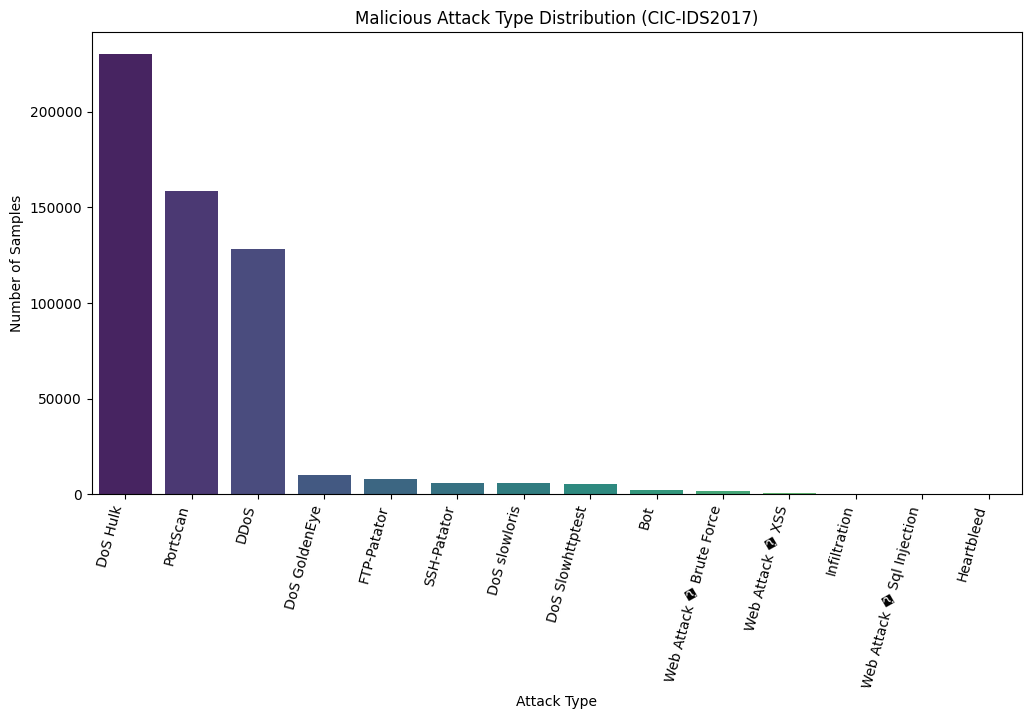

In [25]:
# Attack-only label counts
attack_counts = data[data['Attack'] == 1]['Label'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="viridis")
plt.xticks(rotation=75, ha='right')
plt.title("Malicious Attack Type Distribution (CIC-IDS2017)")
plt.ylabel("Number of Samples")
plt.xlabel("Attack Type")
plt.show()


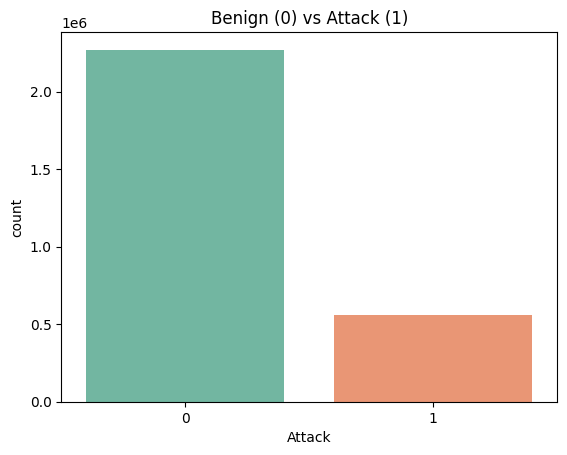

In [26]:
sns.countplot(x='Attack', data=data, palette="Set2")
plt.title("Benign (0) vs Attack (1)")
plt.show()


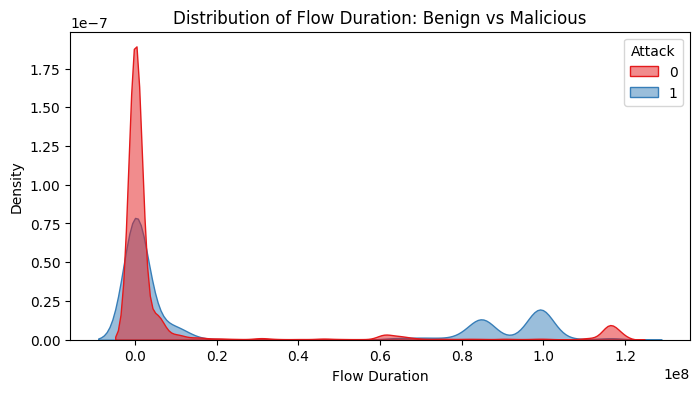

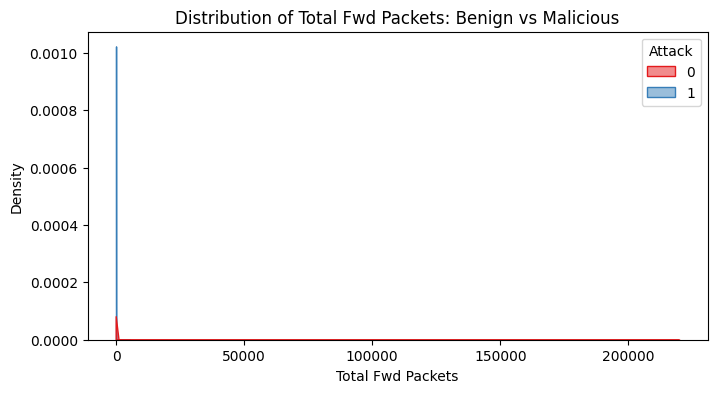

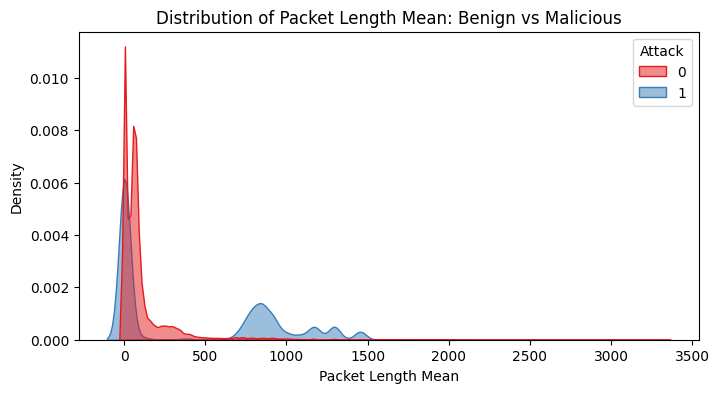

In [27]:
features_to_plot = ['Flow Duration', 'Total Fwd Packets', 'Packet Length Mean']

for feat in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=data, x=feat, hue='Attack', common_norm=False, fill=True, palette="Set1", alpha=0.5)
    plt.title(f"Distribution of {feat}: Benign vs Malicious")
    plt.show()


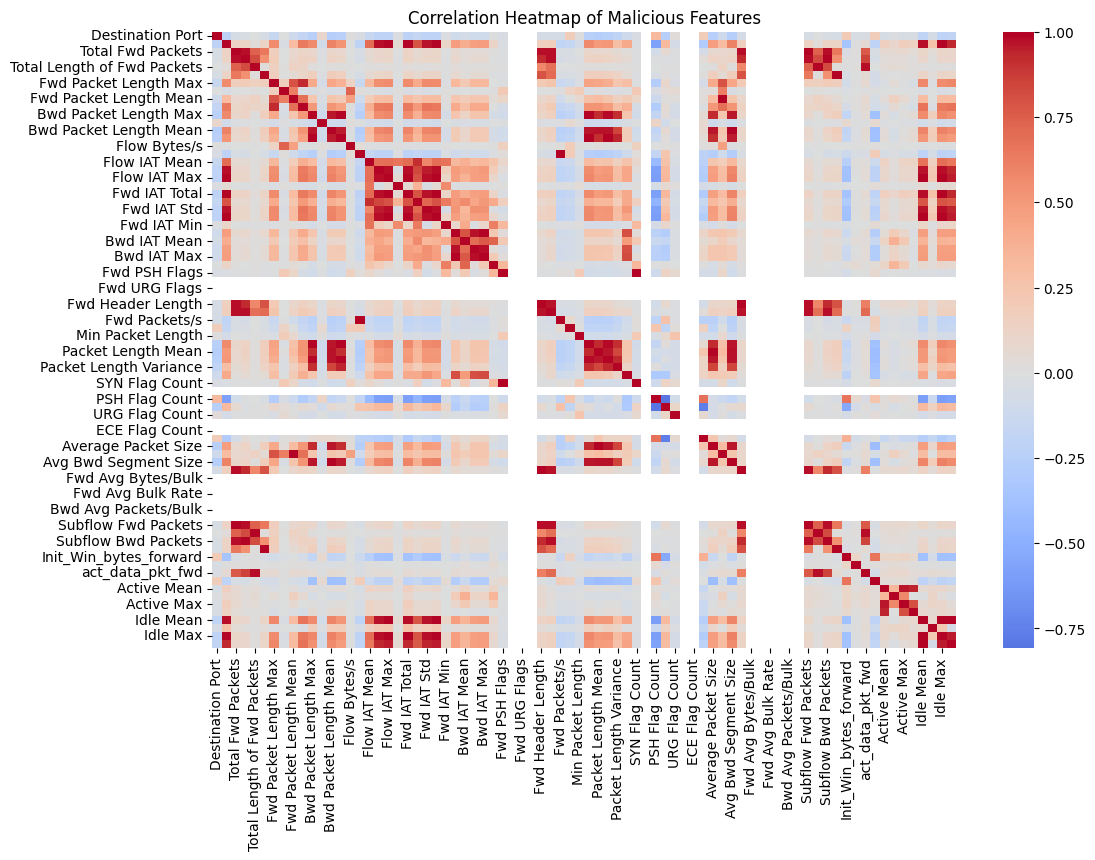

In [28]:
plt.figure(figsize=(12,8))
corr = pd.DataFrame(X_malicious, columns=X.columns).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Malicious Features")
plt.show()
